In [5]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [7]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [8]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [9]:
tf.keras.backend.clear_session()

In [10]:
subject = 'Pará - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [11]:
data = pd.read_csv('2003_raw_Pará_input.csv')
pd.set_option('display.max_columns', None)
data = data.replace(-1.0, np.nan)
data

,data,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - População,Pará - INCC (%),Pará - IPCA - Variação mensal durante o Plano Real (%),Pará - IGP-DI,Pará - Taxa Selic (%),Pará - IDH - Longevidade,Pará - IDH - Renda,Pará - IDH - Educação,Pará - NFSP - Fluxo Mensal (Milhões de reais),Pará - Estoque liquido de capital fixo - (R$),Pará - Desemprego,Pará - Produção de Cimento (t),Pará - Valor,Pará - Consumo de Cimento (t)
0,2003-01-01,3.785855e+06,1.992822e+06,0.586619,2.443525e+06,6453683.0,1.70,12.53,2.70,0.082293,0.725,0.601,0.319,3.46,6.098524e+06,10.770494,NaN,NaN,84701.0
1,2003-02-01,3.785855e+06,1.992822e+06,0.586619,2.443525e+06,6453683.0,1.51,2.25,2.17,0.088771,0.725,0.601,0.319,3.59,6.172460e+06,10.770494,32871.0,NaN,80221.0
2,2003-03-01,3.785855e+06,1.992822e+06,0.586619,2.443525e+06,6453683.0,1.39,3.86,1.59,0.090733,0.725,0.601,0.319,3.84,6.172460e+06,10.770494,48669.0,NaN,76122.0
3,2003-04-01,3.785855e+06,1.992822e+06,0.586619,2.443525e+06,6453683.0,1.38,5.13,1.66,0.092749,0.725,0.601,0.319,3.95,6.172460e+06,10.770494,114467.0,NaN,76544.0
4,2003-05-01,3.785855e+06,1.992822e+06,0.586619,2.443525e+06,6453683.0,0.90,6.15,0.41,0.092758,0.725,0.601,0.319,4.06,6.172460e+06,10.770494,104306.0,NaN,83445.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019-08-01,7.254461e+06,1.224076e+07,0.853716,4.174709e+06,8513497.0,0.58,2.42,-0.01,0.024620,0.790,0.650,0.660,0.69,7.827728e+06,12.300000,295080.0,0.5656,109761.0
200,2019-09-01,7.254461e+06,1.224076e+07,0.853716,4.174709e+06,8513497.0,0.42,2.54,-0.51,0.022751,0.790,0.650,0.660,0.62,7.827728e+06,12.000000,31724.0,0.5620,120188.0
201,2019-10-01,7.254461e+06,1.224076e+07,0.853716,4.174709e+06,8513497.0,0.46,2.49,0.50,0.022035,0.790,0.650,0.660,0.59,7.827728e+06,11.900000,74308.0,0.5704,131620.0
202,2019-11-01,7.254461e+06,1.224076e+07,0.853716,4.174709e+06,8513497.0,0.18,2.60,0.55,0.020790,0.790,0.650,0.660,0.57,7.827728e+06,11.700000,14373.0,0.5684,125374.0


In [12]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data = target_data/1000
target_data

0      115.365
1       90.229
2       87.897
3       96.273
4       97.686
        ...   
199        NaN
200        NaN
201        NaN
202        NaN
203        NaN
Name: Pará - Consumo de Cimento (t), Length: 204, dtype: float64

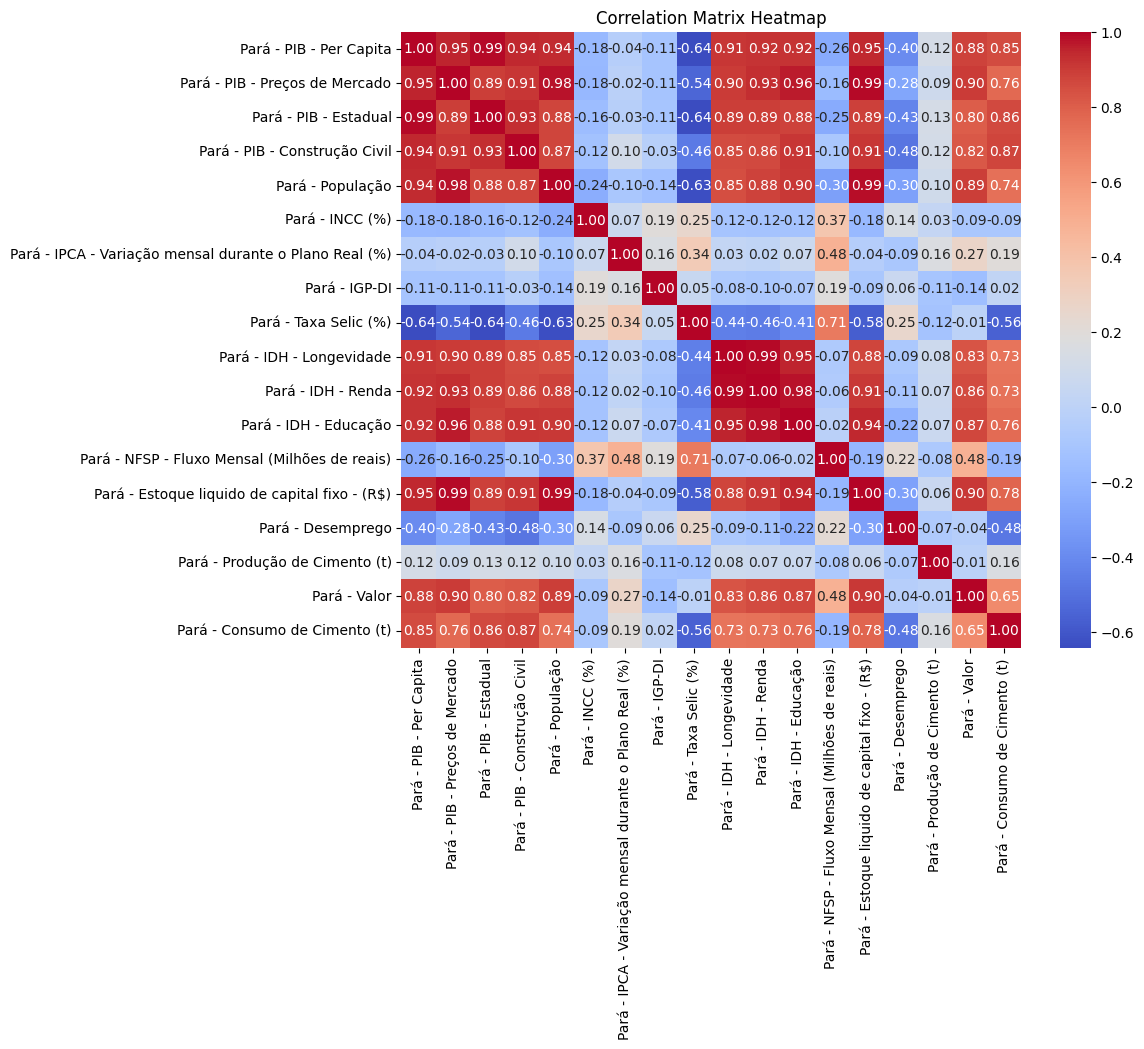

In [13]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [14]:
input_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data = input_data.fillna(-1.0)
input_data

,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - População,Pará - INCC (%),Pará - IPCA - Variação mensal durante o Plano Real (%),Pará - IGP-DI,Pará - Taxa Selic (%),Pará - IDH - Longevidade,Pará - IDH - Renda,Pará - IDH - Educação,Pará - NFSP - Fluxo Mensal (Milhões de reais),Pará - Estoque liquido de capital fixo - (R$),Pará - Desemprego,Pará - Produção de Cimento (t),Pará - Valor
0,-1.475487,-1.322400,-1.358046,-1.046629,-1.737693,1.998868,4.052332,3.466715,2.303195,-0.923705,-0.926030,-0.912388,3.108599,-1.539424,1.202853,-0.583359,-1.563282
1,-1.475487,-1.322400,-1.358046,-1.046629,-1.737693,1.647487,-0.596188,2.630940,2.745235,-0.923705,-0.926030,-0.912388,3.275709,-1.411460,1.202853,-0.467490,-1.563282
2,-1.475487,-1.322400,-1.358046,-1.046629,-1.737693,1.425561,0.131839,1.716318,2.879123,-0.923705,-0.926030,-0.912388,3.597074,-1.411460,1.202853,-0.411804,-1.563282
3,-1.475487,-1.322400,-1.358046,-1.046629,-1.737693,1.407068,0.706121,1.826703,3.016721,-0.923705,-0.926030,-0.912388,3.738475,-1.411460,1.202853,-0.179870,-1.563282
4,-1.475487,-1.322400,-1.358046,-1.046629,-1.737693,0.519367,1.167355,-0.144465,3.017322,-0.923705,-0.926030,-0.912388,3.879875,-1.411460,1.202853,-0.215687,-1.563282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.810792,1.573954,0.447277,0.126599,1.528322,-0.590259,-0.966985,-1.264088,-0.729479,1.311065,1.564962,1.384082,-0.374997,1.441346,1.989415,0.128431,0.884308
176,0.810792,1.573954,0.447277,0.126599,1.528322,-0.479297,-0.881068,-0.412544,-0.941281,1.311065,1.564962,1.384082,-0.439270,1.441346,1.989415,-0.464456,0.883453
177,0.810792,1.573954,0.447277,0.126599,1.528322,-1.034110,-0.808718,0.186692,-1.140710,1.311065,1.564962,1.384082,-0.503543,1.441346,1.989415,-0.273411,0.881742
178,0.810792,1.573954,0.447277,0.126599,1.528322,-0.571766,-0.614276,-0.633314,-1.226481,1.311065,1.564962,1.384082,-0.503543,1.441346,2.059052,-0.517365,0.890297


In [15]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - População,Pará - INCC (%),Pará - IPCA - Variação mensal durante o Plano Real (%),Pará - IGP-DI,Pará - Taxa Selic (%),Pará - IDH - Longevidade,Pará - IDH - Renda,Pará - IDH - Educação,Pará - NFSP - Fluxo Mensal (Milhões de reais),Pará - Estoque liquido de capital fixo - (R$),Pará - Desemprego,Pará - Produção de Cimento (t),Pará - Valor
0,-1.475487,-1.322400,-1.358046,-1.046629,-1.737693,1.998868,4.052332,3.466715,2.303195,-0.923705,-0.926030,-0.912388,3.108599,-1.539424,1.202853,-0.583359,-1.563282
1,-1.475487,-1.322400,-1.358046,-1.046629,-1.737693,1.647487,-0.596188,2.630940,2.745235,-0.923705,-0.926030,-0.912388,3.275709,-1.411460,1.202853,-0.467490,-1.563282
2,-1.475487,-1.322400,-1.358046,-1.046629,-1.737693,1.425561,0.131839,1.716318,2.879123,-0.923705,-0.926030,-0.912388,3.597074,-1.411460,1.202853,-0.411804,-1.563282
3,-1.475487,-1.322400,-1.358046,-1.046629,-1.737693,1.407068,0.706121,1.826703,3.016721,-0.923705,-0.926030,-0.912388,3.738475,-1.411460,1.202853,-0.179870,-1.563282
4,-1.475487,-1.322400,-1.358046,-1.046629,-1.737693,0.519367,1.167355,-0.144465,3.017322,-0.923705,-0.926030,-0.912388,3.879875,-1.411460,1.202853,-0.215687,-1.563282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.942764,1.386943,0.698442,1.468693,1.353065,-0.238878,0.629248,-1.406012,0.272188,0.967254,0.973879,1.384082,0.794771,1.416222,-0.099716,-0.583359,0.856077
164,0.942764,1.386943,0.698442,1.468693,1.353065,-0.608753,0.837256,-0.112926,0.272188,0.967254,0.973879,1.384082,0.730498,1.416222,-0.030078,-0.583359,0.854366
165,0.942764,1.386943,0.698442,1.468693,1.353065,-0.534778,0.877953,-0.743700,0.272188,0.967254,0.973879,1.384082,0.743353,1.416222,0.039559,-0.583359,0.860354
166,0.942764,1.386943,0.698442,1.468693,1.353065,-0.756703,1.000045,-0.586006,0.248413,0.967254,0.973879,1.384082,0.614807,1.416222,0.039559,-0.583359,0.862921


In [16]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      115.365
1       90.229
2       87.897
3       96.273
4       97.686
        ...   
163    133.744
164    128.527
165    147.510
166    138.511
167    103.294
Name: Pará - Consumo de Cimento (t), Length: 168, dtype: float64

In [17]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [18]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 17)

In [19]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - População,Pará - INCC (%),Pará - IPCA - Variação mensal durante o Plano Real (%),Pará - IGP-DI,Pará - Taxa Selic (%),Pará - IDH - Longevidade,Pará - IDH - Renda,Pará - IDH - Educação,Pará - NFSP - Fluxo Mensal (Milhões de reais),Pará - Estoque liquido de capital fixo - (R$),Pará - Desemprego,Pará - Produção de Cimento (t),Pará - Valor
132,1.395825,1.159750,1.479034,1.438340,0.984172,-0.960135,1.058830,0.297077,-0.755853,0.967254,0.973879,1.026377,-0.285015,0.834026,-1.213919,2.322657,0.759405
133,1.395825,1.159750,1.479034,1.438340,0.984172,0.482379,-1.364912,-0.160234,-0.688658,0.967254,0.973879,1.026377,-0.349288,1.129318,-0.865731,-0.345581,0.767960
134,1.395825,1.159750,1.479034,1.438340,0.984172,-0.534778,-1.052901,0.549386,-0.626634,0.967254,0.973879,1.026377,-0.374997,1.129318,-0.656818,-0.583359,0.786781
135,1.395825,1.159750,1.479034,1.438340,0.984172,-0.627247,-0.627842,1.542855,-0.571481,0.967254,0.973879,1.026377,-0.259306,1.129318,-0.796093,-0.583359,0.780793
136,1.395825,1.159750,1.479034,1.438340,0.984172,0.482379,-0.320352,-0.081387,-0.516512,0.967254,0.973879,1.026377,-0.053632,1.129318,-0.935368,-0.583359,0.785926
137,1.395825,1.159750,1.479034,1.438340,0.984172,2.646150,-0.107822,-1.500628,-0.510405,0.967254,0.973879,1.026377,0.023495,1.129318,-1.074644,-0.113277,0.791914
138,1.395825,1.159750,1.479034,1.438340,0.984172,0.075516,0.082098,-1.784477,-0.510405,0.967254,0.973879,1.026377,-0.002214,1.129318,-1.144281,-0.583359,0.809880
139,1.395825,1.159750,1.479034,1.438340,0.984172,0.241960,0.086620,-1.658322,-0.510405,0.967254,0.973879,1.026377,-0.143614,1.129318,-1.283557,-0.583359,0.812446
140,1.395825,1.159750,1.479034,1.438340,0.984172,-0.997122,0.204189,-0.696392,-0.510054,0.967254,0.973879,1.026377,-0.182178,1.129318,-1.422832,-0.583359,0.814157
141,1.395825,1.159750,1.479034,1.438340,0.984172,-0.867666,0.470982,-0.759469,-0.510405,0.967254,0.973879,1.026377,-0.105051,1.129318,-1.562107,-0.136457,0.809880


In [20]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 17)

In [21]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [18]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [19]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [22]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [23]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[3943284033, 3382615500, 837651142, 3616453487, 3338219497, 770262879, 4047984043, 1380829639, 3098527620, 1208349422]


Step: 0 ___________________________________________
val_loss: 280.55548095703125
winner_seed: 3943284033


Step: 1 ___________________________________________
val_loss: 350.316162109375


Step: 2 ___________________________________________
val_loss: 241.7458953857422
winner_seed: 837651142


Step: 3 ___________________________________________
val_loss: 81178816.0


Step: 4 ___________________________________________
val_loss: 411.19403076171875


Step: 5 ___________________________________________
val_loss: 463.13726806640625


Step: 6 ___________________________________________
val_loss: 421.3558654785156


Step: 7 ___________________________________________
val_loss: 446.67437744140625


Step: 8 ___________________________________________
val_loss: 402.6311340332031


Step: 9 ___________________________________________
val_loss: 347.32342529296875
1/1 [============

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,128.169617,131.51178,129.153091,134.50415,138.945816,144.344208,156.417465,182.519714,190.199707,194.386169,205.839386,211.278687
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,17.465614,39.873779,38.409088,52.396149,41.455818,47.541206,37.730469,72.758713,70.011703,62.766174,80.465385,95.46769


[3895640160, 1449400100, 1502381874, 1260047647, 1556034251, 2364739537, 3243036843, 1546536779, 3501831800, 992562189]


Step: 0 ___________________________________________
val_loss: 423.79534912109375
winner_seed: 3895640160


Step: 1 ___________________________________________
val_loss: 397.7935485839844
winner_seed: 1449400100


Step: 2 ___________________________________________
val_loss: 338.063720703125
winner_seed: 1502381874


Step: 3 ___________________________________________
val_loss: 173.19985961914062
winner_seed: 1260047647


Step: 4 ___________________________________________
val_loss: 339.1944274902344


Step: 5 ___________________________________________
val_loss: 199.1540985107422


Step: 6 ___________________________________________
val_loss: 374.6543884277344


Step: 7 ___________________________________________
val_loss: 430.2460021972656


Step: 8 ___________________________________________
val_loss: 246.21316528320312


Step: 9 __________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,111.228119,80.720596,96.687119,124.475983,154.923615,174.08046,173.075531,195.593582,212.390274,212.119385,206.239197,196.366592
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,0.524117,10.917404,5.943115,42.367981,57.433617,77.277458,54.388535,85.832581,92.202271,80.49939,80.865196,80.555595


[2346553225, 4273750248, 1686720678, 3246583994, 3567564504, 4169267732, 1222283053, 2822560163, 1266334218, 947176022]


Step: 0 ___________________________________________
val_loss: 268.0251770019531
winner_seed: 2346553225


Step: 1 ___________________________________________
val_loss: 1106762399744.0


Step: 2 ___________________________________________
val_loss: 334.8684997558594


Step: 3 ___________________________________________
val_loss: 353.0077209472656


Step: 4 ___________________________________________
val_loss: 296.8075256347656


Step: 5 ___________________________________________
val_loss: 276.14007568359375


Step: 6 ___________________________________________
val_loss: 307.25091552734375


Step: 7 ___________________________________________
val_loss: 230.1833038330078
winner_seed: 2822560163


Step: 8 ___________________________________________
val_loss: 382.033935546875


Step: 9 ___________________________________________
val_loss: 315.1009216308594
1/1 [========

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,122.828316,122.333199,129.860504,133.031387,151.837326,170.682602,169.876633,186.540253,195.23912,206.261978,210.583969,207.067932
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,12.124313,30.695198,39.116501,50.923386,54.347328,73.879601,51.189636,76.779251,75.051117,74.641983,85.209969,91.256935


[1206500160, 2668154724, 1205070136, 2623836824, 3291260307, 2838632502, 183207044, 2783165664, 2369586958, 1071966633]


Step: 0 ___________________________________________
val_loss: 386.57159423828125
winner_seed: 1206500160


Step: 1 ___________________________________________
val_loss: 269.03253173828125
winner_seed: 2668154724


Step: 2 ___________________________________________
val_loss: 253.16458129882812
winner_seed: 1205070136


Step: 3 ___________________________________________
val_loss: 254.84390258789062


Step: 4 ___________________________________________
val_loss: 485.5699768066406


Step: 5 ___________________________________________
val_loss: 320.6824951171875


Step: 6 ___________________________________________
val_loss: 278.6837158203125


Step: 7 ___________________________________________
val_loss: 266.89971923828125


Step: 8 ___________________________________________
val_loss: 291.8878173828125


Step: 9 ___________________________________________
val_loss: 5

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,119.869202,113.606293,141.626831,148.039352,155.299026,169.354294,167.066864,183.794708,192.799652,193.48053,193.801941,193.995026
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,9.165199,21.968292,50.882828,65.931351,57.809029,72.551292,48.379868,74.033707,72.611649,61.860535,68.42794,78.184029


[1205707083, 3459833537, 518827006, 363224888, 2196585900, 2395379426, 1324623107, 3428813401, 1032438569, 1229118184]


Step: 0 ___________________________________________
val_loss: 226.3459930419922
winner_seed: 1205707083


Step: 1 ___________________________________________
val_loss: 218.9118194580078
winner_seed: 3459833537


Step: 2 ___________________________________________
val_loss: 516.0905151367188


Step: 3 ___________________________________________
val_loss: 371.47625732421875


Step: 4 ___________________________________________
val_loss: 600.6917114257812


Step: 5 ___________________________________________
val_loss: 365.67486572265625


Step: 6 ___________________________________________
val_loss: 334.6326904296875


Step: 7 ___________________________________________
val_loss: 244.940673828125


Step: 8 ___________________________________________
val_loss: 232.29074096679688


Step: 9 ___________________________________________
val_loss: 263.8601379394531
1/1 [======

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,125.834908,124.713554,135.431046,156.472275,180.455841,191.263107,193.820572,206.376785,209.617142,209.991959,212.010956,211.300827
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,15.130905,33.075554,44.687042,74.364273,82.965843,94.460106,75.133575,96.615784,89.429138,78.371964,86.636955,95.48983


[4018371683, 4162895728, 4222650467, 2347748037, 252388999, 3083513406, 1727274957, 2014684113, 2272055464, 2240826765]


Step: 0 ___________________________________________
val_loss: 274.7881164550781
winner_seed: 4018371683


Step: 1 ___________________________________________
val_loss: 265.65789794921875
winner_seed: 4162895728


Step: 2 ___________________________________________
val_loss: 205.6882781982422
winner_seed: 4222650467


Step: 3 ___________________________________________
val_loss: 252.88623046875


Step: 4 ___________________________________________
val_loss: 125.5934829711914
winner_seed: 252388999


Step: 5 ___________________________________________
val_loss: 307.0310363769531


Step: 6 ___________________________________________
val_loss: 361.5467224121094


Step: 7 ___________________________________________
val_loss: 182.66290283203125


Step: 8 ___________________________________________
val_loss: 215.23141479492188


Step: 9 ____________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,127.164955,100.028709,120.095863,149.087875,144.896667,152.454407,166.590836,164.416382,161.608246,160.035339,183.949142,192.37355
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,16.460953,8.390709,29.35186,66.979874,47.40667,55.651405,47.903839,54.65538,41.420242,28.415344,58.575142,76.562553


[3660110487, 1364018976, 1433183412, 981658603, 3302434444, 3089526859, 1103233536, 2295237357, 2045249099, 858740810]


Step: 0 ___________________________________________
val_loss: 207.50375366210938
winner_seed: 3660110487


Step: 1 ___________________________________________
val_loss: 149.48158264160156
winner_seed: 1364018976


Step: 2 ___________________________________________
val_loss: 316.92340087890625


Step: 3 ___________________________________________
val_loss: 356.4065856933594


Step: 4 ___________________________________________
val_loss: 298.98370361328125


Step: 5 ___________________________________________
val_loss: 300.79150390625


Step: 6 ___________________________________________
val_loss: 276.1273498535156


Step: 7 ___________________________________________
val_loss: 536.2636108398438


Step: 8 ___________________________________________
val_loss: 233.80447387695312


Step: 9 ___________________________________________
val_loss: 195.57839965820312
1/1 [====

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,121.15464,135.007339,143.73201,176.677368,186.274796,186.340134,180.158722,203.71167,191.892838,195.407211,188.696732,188.75621
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,10.450638,43.369339,52.988007,94.569366,88.784798,89.537132,61.471725,93.950668,71.704834,63.787216,63.322731,72.945213


[4271886150, 4077671446, 2890618073, 2905836503, 2752184305, 1870057999, 2793674162, 883920618, 4157499148, 1458885536]


Step: 0 ___________________________________________
val_loss: 458.9371032714844
winner_seed: 4271886150


Step: 1 ___________________________________________
val_loss: 522.3967895507812


Step: 2 ___________________________________________
val_loss: 319.4375305175781
winner_seed: 2890618073


Step: 3 ___________________________________________
val_loss: 277.48736572265625
winner_seed: 2905836503


Step: 4 ___________________________________________
val_loss: 218.66897583007812
winner_seed: 2752184305


Step: 5 ___________________________________________
val_loss: 216.2000732421875
winner_seed: 1870057999


Step: 6 ___________________________________________
val_loss: 201.2481231689453
winner_seed: 2793674162


Step: 7 ___________________________________________
val_loss: 258.2505798339844


Step: 8 ___________________________________________
val_loss: 237.486328125


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,117.370117,107.128761,108.14756,116.798859,124.878517,138.807587,154.960251,176.836975,175.644531,174.698578,171.636551,175.021698
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,6.666115,15.490761,17.403557,34.690857,27.388519,42.004585,36.273254,67.075974,55.456528,43.078583,46.26255,59.210701


[2235837469, 519910493, 3745693899, 3546124603, 2277890273, 2466139599, 1586670681, 1423482739, 1968116246, 315905342]


Step: 0 ___________________________________________
val_loss: 369.11383056640625
winner_seed: 2235837469


Step: 1 ___________________________________________
val_loss: 548.8206787109375


Step: 2 ___________________________________________
val_loss: 390.47503662109375


Step: 3 ___________________________________________
val_loss: 258.5173034667969
winner_seed: 3546124603


Step: 4 ___________________________________________
val_loss: 272.630615234375


Step: 5 ___________________________________________
val_loss: 383.7891845703125


Step: 6 ___________________________________________
val_loss: 181.26097106933594
winner_seed: 1586670681


Step: 7 ___________________________________________
val_loss: 570.2144775390625


Step: 8 ___________________________________________
val_loss: 280.0600280761719


Step: 9 ___________________________________________
val_loss: 309.6

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,135.639313,126.68029,158.703369,181.377975,191.229019,191.734055,191.918808,192.171005,204.067078,204.944077,206.632416,206.404694
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,24.93531,35.04229,67.959366,99.269974,93.739021,94.931053,73.231812,82.410004,83.879074,73.324081,81.258415,90.593697


[3695586417, 3577681120, 2322729162, 1224649717, 216655619, 2849763992, 3235198957, 868004429, 2087373456, 3753007230]


Step: 0 ___________________________________________
val_loss: 231.33444213867188
winner_seed: 3695586417


Step: 1 ___________________________________________
val_loss: 192.32192993164062
winner_seed: 3577681120


Step: 2 ___________________________________________
val_loss: 565.5906372070312


Step: 3 ___________________________________________
val_loss: 558.69921875


Step: 4 ___________________________________________
val_loss: 327.77001953125


Step: 5 ___________________________________________
val_loss: 186.79129028320312
winner_seed: 2849763992


Step: 6 ___________________________________________
val_loss: 245.1342010498047


Step: 7 ___________________________________________
val_loss: 229.1827392578125


Step: 8 ___________________________________________
val_loss: 405.04437255859375


Step: 9 ___________________________________________
val_loss: 288.416748

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,105.629578,86.298508,88.575516,108.260529,141.393997,152.962509,160.282394,171.155472,179.579834,177.989258,176.475845,174.063614
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,5.074425,5.339493,2.168488,26.152527,43.903999,56.159508,41.595398,61.39447,59.39183,46.369263,51.101845,58.252617


'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,121.488892,112.802895,125.201309,142.872574,157.013474,167.202347,171.416794,186.311661,191.303833,192.931458,195.586624,195.662888
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,10.784892,21.164895,34.457309,60.764574,59.523474,70.399347,52.729794,76.550661,71.115833,61.311458,70.212624,79.851888


In [24]:
display(mae)
display(mape)

163.31622

0.5195602635837439